### Hypothesis Testing
We will put into practice what we saw in the slides by constructing confidence intervals using the movies dataset. CI's are usually constructed around the average value for group(s) within a sample. We can do this for any of the numerical values in the movies dataset, such as the rating, our groupings can be the genres.

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [2]:
## Load the movies dataset ##
movies = pd.read_csv("../Data/movies.csv")
movies

,title,genre,director,year,duration,gross,budget,cast_facebook_likes,votes,reviews,rating
0,Avatar,Action,James Cameron,2009,178,760505847,237000000,4834,886204,3777,7.9
1,Titanic,Drama,James Cameron,1997,194,658672302,200000000,45223,793059,2843,7.7
2,Jurassic World,Action,Colin Trevorrow,2015,124,652177271,150000000,8458,418214,1934,7.0
3,The Avengers,Action,Joss Whedon,2012,173,623279547,220000000,87697,995415,2425,8.1
4,The Dark Knight,Action,Christopher Nolan,2008,152,533316061,185000000,57802,1676169,5312,9.0
...,...,...,...,...,...,...,...,...,...,...,...
2956,Locker 13,Thriller,Bruce Dellis,2014,95,2468,300000,2048,241,15,4.8
2957,The Ghastly Love of Johnny X,Comedy,Paul Bunnell,2012,106,2436,2000000,1611,344,113,5.7
2958,Detention of the Dead,Comedy,Alex Craig Mann,2012,87,1332,500000,2251,2038,49,4.6
2959,The Trials of Darryl Hunt,Crime,Ricki Stern,2006,106,1111,200000,2,771,21,7.7


In [3]:
# Take the IMDb ratings column (replace with actual column name)
ratings = movies["rating"].dropna()  # Remove any missing values from the ratings column

# STEP 1: What you observe (Sample Statistics)
sample_mean = ratings.mean()          # Calculate the sample mean (x̄)
sample_std = ratings.std()            # Calculate the sample standard deviation (s)
n = len(ratings)                      # Get the sample size (n)

# STEP 2: What you believe (Null Hypothesis)
mu_0 = 7  # null hypothesis: H₀: μ = 7 (population mean equals 7)
          # Alternative hypothesis: H₁: μ ≠ 7 (two-sided test)

# STEP 3: Test statistic (t-statistic)
# Formula: t = (x̄ - μ₀) / (s / √n)
# This measures how many standard errors the sample mean is from the hypothesized mean
t_stat = (sample_mean - mu_0) / (sample_std / (n**0.5)) # n**0.5 means square root of n

# Degrees of freedom for t-distribution
df = n - 1  # df = sample size - 1

# STEP 4: Calculate p-value for two-sided test
# P-value = probability of observing a test statistic as extreme or more extreme
# For two-sided test: P(|T| >= |t_observed|) = 2 × P(T >= |t_observed|)
p_value = 2 * (1 - stats.t.cdf(abs(t_stat), df))

# Display results
print(f"Sample size: {n}")
print(f"Sample mean: {sample_mean:.3f}")
print(f"Test statistic (t): {t_stat:.3f}")
print(f"P-value: {p_value:.4f}")

# Interpretation:
# If p_value < 0.05: Reject H₀ (evidence against μ = 7)
# If p_value >= 0.05: Fail to reject H₀ (insufficient evidence against μ = 7)
# test statistic can be negative or positive depending on whether sample mean is less than or greater than mu_0

Sample size: 2961
Sample mean: 6.389
Test statistic (t): -31.604
P-value: 0.0000


Its a good idea to investigate our data and learn what values/variables it contains, what summary statistics we can draw from the data.

In [4]:
# Display basic statistics of the dataset
movies.describe()

# Count the number of movies per genre
movies['genre'].value_counts()


genre
Comedy         848
Action         738
Drama          498
Adventure      288
Crime          202
Biography      135
Horror         131
Animation       35
Fantasy         28
Documentary     25
Mystery         16
Sci-Fi           7
Family           3
Musical          2
Romance          2
Western          2
Thriller         1
Name: count, dtype: int64

As the confidence interval relies on the number of samples (n) we would like to work with larger numbers, for now let's remove the observations <=3. Althought Sci-Fi with 7 observations isnt ideal, it would allow us to see how smaller samples sizes affect the CI when we visualise them later.

In [5]:
# Choose genres with at least 5 movies
genres_to_choose = (movies
                    .groupby('genre') # Group by genre
                    .size() # Count the number of movies in each genre
                    .reset_index(name='count') # Reset the index and name the count column
                    .query('count >= 5') # Filter genres with at least 5 movies
)

# Display the filtered genres
genres_to_choose

,genre,count
0,Action,738
1,Adventure,288
2,Animation,35
3,Biography,135
4,Comedy,848
5,Crime,202
6,Documentary,25
7,Drama,498
9,Fantasy,28
10,Horror,131


In [6]:
# Confidence Interval (CI) using the formula mean +- t_critical * SE

# Filter movies by selected genres
filtered_movies = movies[movies['genre'].isin(genres_to_choose['genre'])]

# Group by genre and calculate statistics
genre_formula_ci = (
    filtered_movies
    .groupby('genre')
    .agg(
        mean_rating=('rating', 'mean'),
        median_rating=('rating', 'median'),
        sd_rating=('rating', 'std'),
        count=('rating', 'size')
    )
    .reset_index()
)

# Calculate additional statistics for confidence intervals
genre_formula_ci['t_critical'] = genre_formula_ci['count'].apply(lambda n: stats.t.ppf(0.975, df=n-1))  # t-critical value
genre_formula_ci['se_rating'] = genre_formula_ci['sd_rating'] / np.sqrt(genre_formula_ci['count'])  # Standard error
genre_formula_ci['margin_of_error'] = genre_formula_ci['t_critical'] * genre_formula_ci['se_rating']  # Margin of error
genre_formula_ci['rating_low'] = genre_formula_ci['mean_rating'] - genre_formula_ci['margin_of_error']  # Lower bound
genre_formula_ci['rating_high'] = genre_formula_ci['mean_rating'] + genre_formula_ci['margin_of_error']  # Upper bound

# Sort by mean rating in descending order
genre_formula_ci = genre_formula_ci.sort_values(by='mean_rating', ascending=False)

# Display the result
genre_formula_ci

,genre,mean_rating,median_rating,sd_rating,count,t_critical,se_rating,margin_of_error,rating_low,rating_high
3,Biography,7.114074,7.20,0.759827,135,1.977826,0.065396,0.129341,6.984733,7.243415
5,Crime,6.915347,6.90,0.849356,202,1.971837,0.059760,0.117838,6.797509,7.033184
10,Mystery,6.856250,6.90,0.881641,16,2.131450,0.220410,0.469794,6.386456,7.326044
7,Drama,6.731526,6.80,0.916993,498,1.964749,0.041091,0.080734,6.650792,6.812260
6,Documentary,6.660000,7.40,1.766588,25,2.063899,0.353318,0.729212,5.930788,7.389212
11,Sci-Fi,6.657143,6.40,1.093705,7,2.446912,0.413382,1.011508,5.645635,7.668651
2,Animation,6.651429,6.90,0.968131,35,2.032245,0.163644,0.332565,6.318864,6.983993
1,Adventure,6.506597,6.60,1.093881,288,1.968264,0.064458,0.126870,6.379728,6.633467
0,Action,6.232249,6.30,1.030362,738,1.963188,0.037928,0.074460,6.157789,6.306709
8,Fantasy,6.153571,6.45,0.958966,28,2.051831,0.181228,0.371848,5.781723,6.525420


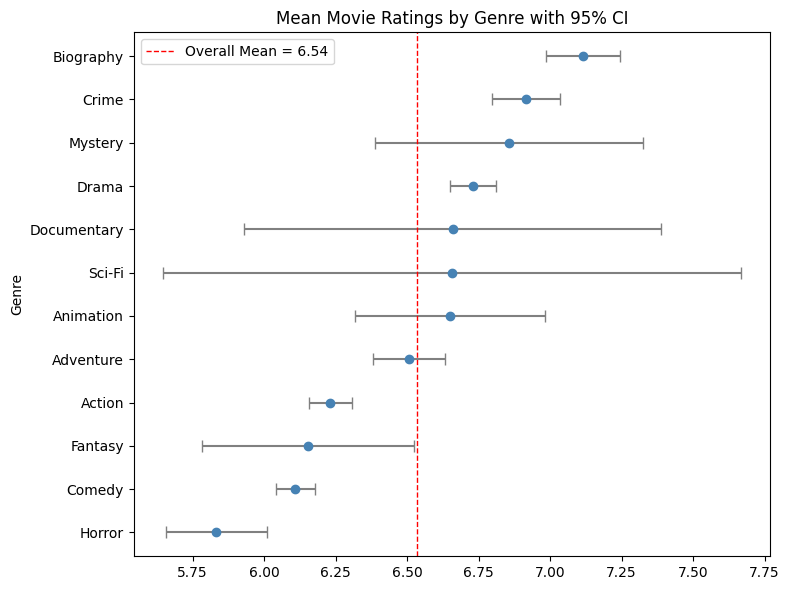

In [7]:
# Sort for plotting
plot_df = genre_formula_ci.sort_values('mean_rating', ascending=True)

plt.figure(figsize=(8, 6))

# Plot the mean ratings as points with horizontal error bars
plt.errorbar(
    x=plot_df['mean_rating'],            # mean rating
    y=plot_df['genre'],                   # genre labels
    xerr=plot_df['margin_of_error'],      # half-length of CI
    fmt='o',                              # point marker
    color='steelblue',                    # point color
    ecolor='gray',                        # error bar color
    capsize=4,                            # cap size on error bars
    markersize=6                          # marker size
)

# Add a vertical line for overall mean rating
overall_mean = plot_df['mean_rating'].mean()
plt.axvline(
    overall_mean,
    color='red', linestyle='--', linewidth=1,
    label=f'Overall Mean = {overall_mean:.2f}'
)

# Labels and title\ plt.xlabel('Mean Rating')
plt.ylabel('Genre')
plt.title('Mean Movie Ratings by Genre with 95% CI')
plt.legend()
plt.tight_layout()
# plt.savefig('mean_movie_ratings_by_genre.png', dpi=300)  # Save the plot as a PNG file
plt.show()

# Analysis
- If they don't overlap, we can say that they are different
- If they overlap, we need to perform another test to further analyze the means

# Hypothesis Testing Framework

How do we know something works?

1. What you Observe
2. What you believe (Null Hypothesis)
3. How far apart is what you observe from what you believe

What the sample tells you
We calculated the mean rating of all movies from IMDB = 6.389

Default (Null) Hypothesis

# Type 1 & Type 2 Errors
- Type 1 error, false positive. Alpha = Pr(reject null when H0 is true)
- Type 2 error, false negative. Beta = Pr(fails to reject null when Ha is true)
